In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('data//vcf_with_labels.csv')
samples = df['samples']
df = df.drop(columns = ['samples', 'score'])
df.head(10)

label  chr22:16050408:T:C  chr22:16050612:C:G  chr22:16050678:C:T  \
0      0                   0                   1                   0   
1      1                   1                   1                   1   
2      0                   1                   1                   1   
3      0                   0                   0                   0   
4      0                   0                   1                   0   
5      1                   1                   1                   1   
6      0                   0                   0                   0   
7      1                   0                   0                   0   
8      1                   0                   0                   0   
9      1                   1                   1                   1   

   chr22:16050984:C:G  chr22:16051107:C:A  chr22:16051249:T:C  \
0                   0                   0                   0   
1                   0                   1                   1   
2                   0                   1                   1   
3                   0                   0                   0   
4                   0                   1                   0   
5                   0                   1                   1   
6                   0                   0                   0   
7                   0                   0                   1   
8                   0                   0                   0   
9                   0                   1                   1   

   chr22:16051347:G:C  chr22:16051453:A:C  chr22:16051477:C:A  \
0                   0                   0                   0   
1                   1                   1                   0   
2                   1                   1                   0   
3                   1                   0                   0   
4                   1                   0                   0   
5                   1                   1                   0   
6                   0                   0                   0   
7                   1                   1                   0   
8                   2                   0                   0   
9                   1                   1                   0   

   chr22:16051480:T:C  chr22:16051497:A:G  chr22:16051722:TA:T  \
0                   0                   0                    0   
1                   1                   1                    0   
2                   1                   1                    0   
3                   0                   1                    0   
4                   1                   1                    0   
5                   1                   1                    0   
6                   0                   0                    0   
7                   0                   1                    0   
8                   0                   2                    0   
9                   1                   1                    0   

   chr22:16051867:T:C  chr22:16051882:C:T  chr22:16052080:G:A  \
0                   0                   0                   1   
1                   0                   1                   0   
2                   0                   1                   0   
3                   0                   0                   0   
4                   0                   1                   0   
5                   0                   1                   0   
6                   0                   0                   1   
7                   0                   0                   0   
8                   0                   0                   0   
9                   0                   1                   0   

   chr22:16052112:C:G  chr22:16052159:T:C  chr22:16052239:A:G  \
0                   0                   0                   1   
1                   0                   0                   1   
2                   0                   0                   0   
3                   0                   0                   1   
4         

In [3]:
target = df.label.values
Data = df.drop(columns = 'label').values
D_train, D_test, t_train, t_test = train_test_split(Data, 
                                                    target, 
                                                    test_size = 0.3,
                                                    random_state=999,
                                                    stratify=target)

print("Orginal dataset shape:", df.shape)
print("Features training dataset shape after split:", D_train.shape)
print("Features test dataset shape after split:", D_test.shape)
print("Target training dataset shape after split:", t_train.shape)
print("Target test dataset shape after split:", t_test.shape)

Orginal dataset shape: (1033, 1989)
Features training dataset shape after split: (723, 1988)
Features test dataset shape after split: (310, 1988)
Target training dataset shape after split: (723,)
Target test dataset shape after split: (310,)


In [4]:
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                     n_repeats=3,
                                    random_state=999)

In [5]:
scoring_metric = 'accuracy'

In [6]:
rf_classifier = RandomForestClassifier(random_state = 999)
rf_cv_results_full = cross_val_score(estimator=rf_classifier,
                                    X=D_test,
                                    y=t_test,
                                   cv=cv_method, 
                                   scoring=scoring_metric)
rf_cv_results_full.mean().round(3)

0.58

In [7]:
num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100)
model_rfi.fit(D_train, t_train)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [8]:
best_features_rfi = df.columns[fs_indices_rfi].values
print('The top 10 features are:', ", ".join([str(i) for i in best_features_rfi]))

The top 10 features are: chr22:17712566:C:T, chr22:17770344:A:T, chr22:16053509:A:G, chr22:17741724:T:C, chr22:17725695:A:G, chr22:17699214:T:C, chr22:17725150:C:T, chr22:16052159:T:C, chr22:17722442:A:T, chr22:17713320:C:G


In [9]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
print('The importance scores for the previous 10 features are:', ", ".join([str(round(i,4)) for i in feature_importances_rfi]))

The importance scores for the previous 10 features are: 0.0052, 0.0047, 0.0039, 0.0039, 0.0038, 0.0038, 0.0037, 0.0036, 0.0036, 0.0036


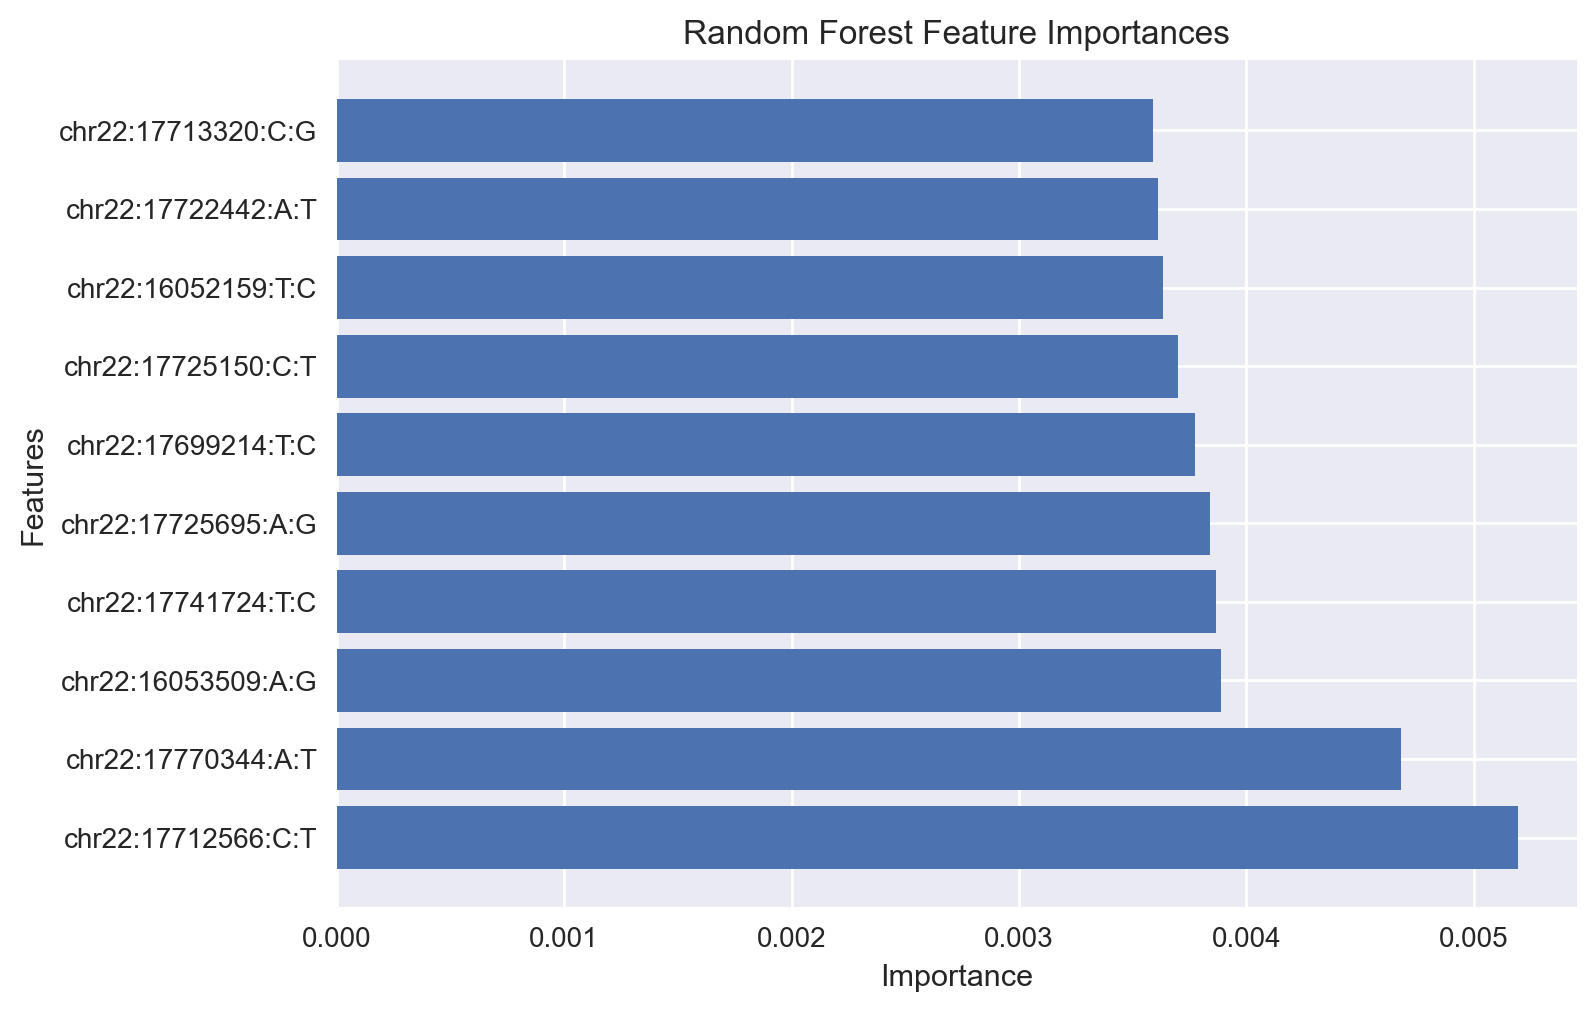

In [10]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest')

In [11]:
params_RF = {'criterion': ['gini', 'entropy'],
             'n_estimators':[100, 250, 500],
             'max_depth': [2,5,7,10,12]}

gs_RF = GridSearchCV(estimator=rf_classifier, 
                     param_grid=params_RF, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='roc_auc')
gs_RF.fit(D_train,t_train)

Fitting 15 folds for each of 30 candidates, totalling 450 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=RandomForestClassifier(random_state=999),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 7, 10, 12],
                         'n_estimators': [100, 250, 500]},
             scoring='roc_auc', verbose=1)

In [12]:
print('The best parameters for Random Forest Classifier are: ', gs_RF.best_params_)

The best parameters for Random Forest Classifier are:  {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 500}


In [13]:
print("The best score using area under the ROC curve metric is:", round(gs_RF.best_score_,3))

The best score using area under the ROC curve metric is: 0.618


In [14]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']
results_RF.nlargest(n=10, columns=['test_score']).style.highlight_max(subset = ['test_score'],color = 'lightgreen', axis = 0)

,criterion,max_depth,n_estimators,test_score
14,gini,12,500,0.618329
6,gini,7,100,0.617477
13,gini,12,250,0.617120
8,gini,7,500,0.616576
11,gini,10,500,0.616189
7,gini,7,250,0.615809
10,gini,10,250,0.614294
29,entropy,12,500,0.614123
12,gini,12,100,0.613980
9,gini,10,100,0.613275


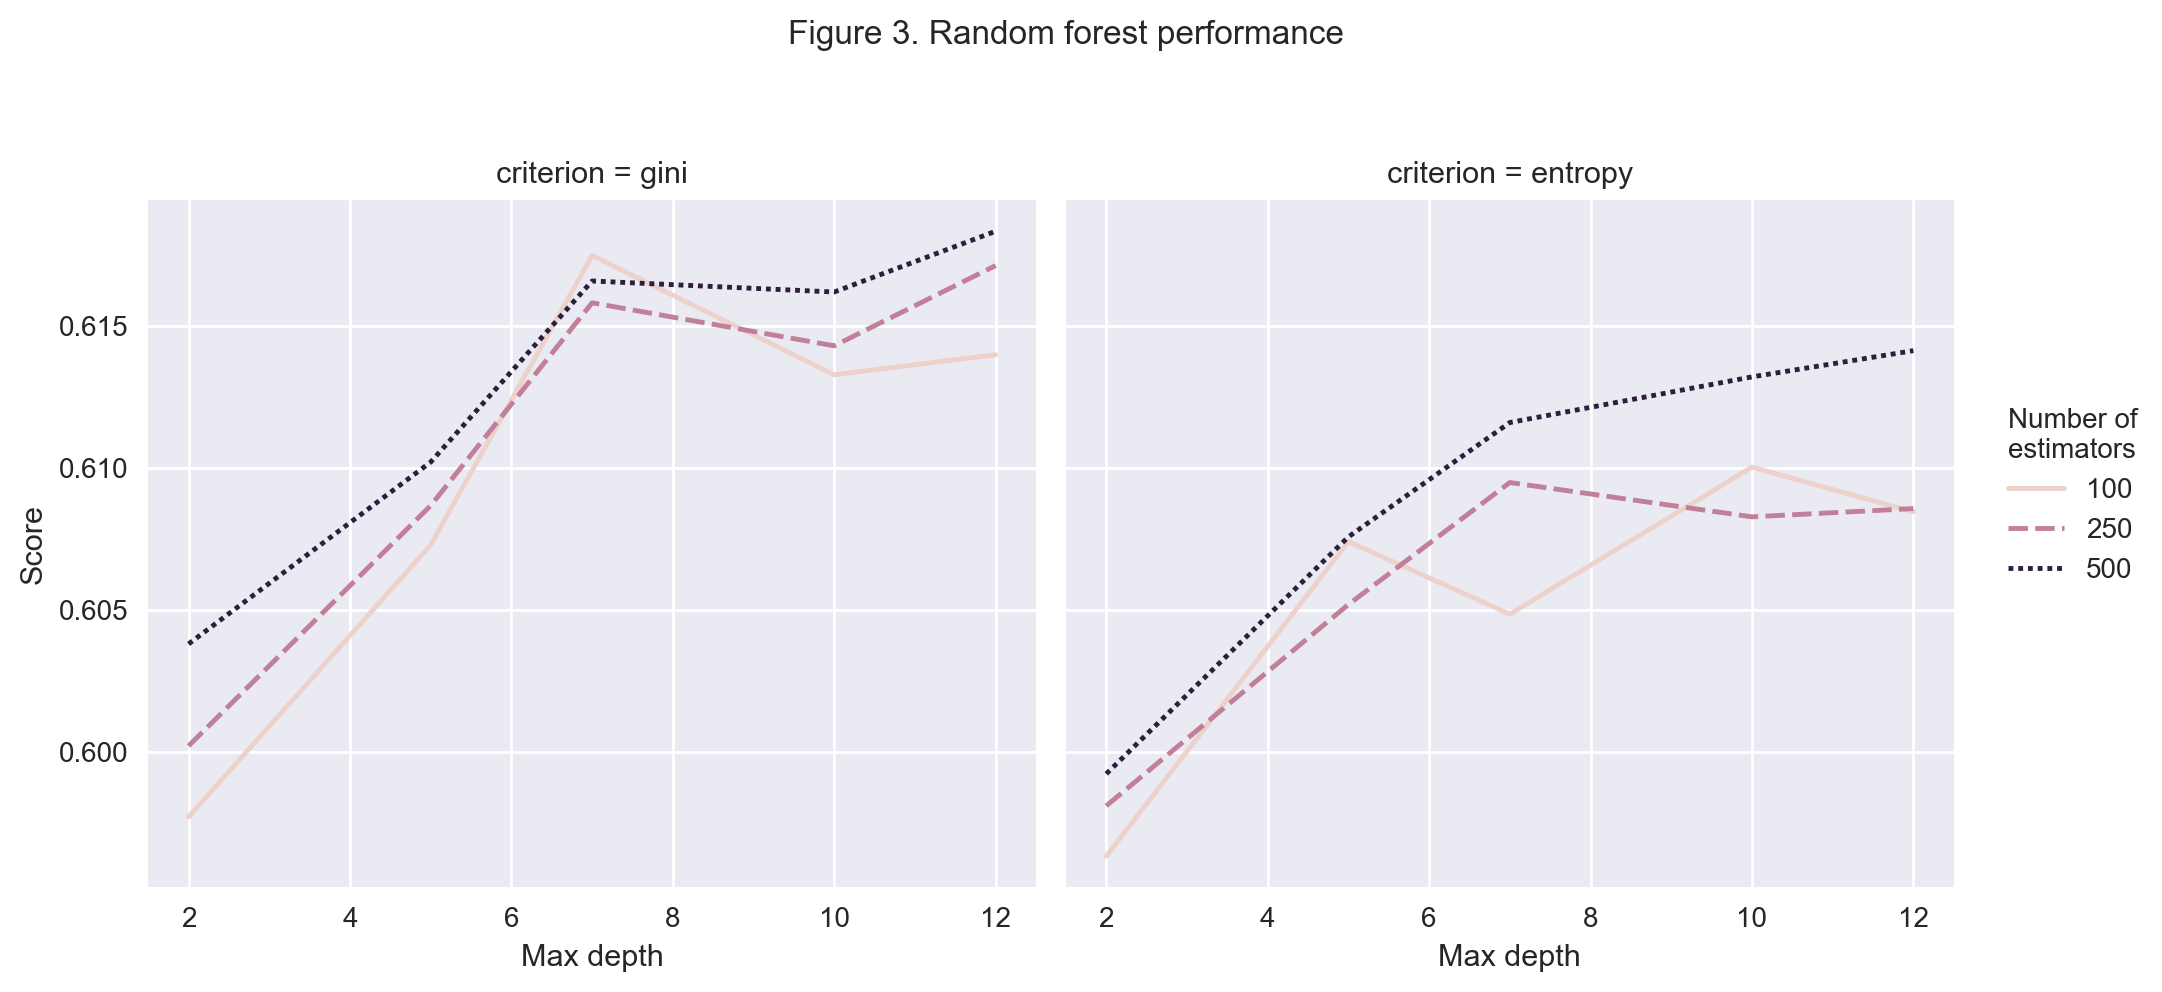

In [15]:
rel_plot=sns.relplot(data=results_RF,
            x='max_depth',
            y='test_score',
           col='criterion',
           hue='n_estimators', style="n_estimators",
           kind='line')
rel_plot.axes[0,0].set_xlabel('Max depth')
rel_plot.axes[0,1].set_xlabel('Max depth')
rel_plot.axes[0,0].set_ylabel('Score')
rel_plot._legend.set_title("Number of\nestimators")
rel_plot._legend._legend_box.align="left"
rel_plot.fig.subplots_adjust(top=0.8)
rel_plot.fig.suptitle("Figure 3. Random forest performance")
plt.show(rel_plot)

In [16]:
rf = RandomForestClassifier(n_estimators = results_RF['n_estimators'].iloc[0],
                           criterion = results_RF['criterion'].iloc[0],
                          max_depth = results_RF['max_depth'].iloc[0])
rf.fit(D_train, t_train)
predictions = rf.predict(D_test)

In [17]:
pred_df = pd.DataFrame({'actual_label':t_test,'predicted_label':predictions})

In [18]:
pred_df.head(10)

,actual_label,predicted_label
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,1,0
9,1,0


In [19]:
accuracy_score(t_test, predictions)

0.603225806451613

In [20]:
print(classification_report(t_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.99      0.75       185
           1       0.67      0.03      0.06       125

    accuracy                           0.60       310
   macro avg       0.63      0.51      0.40       310
weighted avg       0.63      0.60      0.47       310



In [ ]:
# Data Augmentation Here
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
file_path = r'D:\data-augmentation-genetics\vcf_with_labels.csv'
df = pd.read_csv(file_path)

# Split features and labels
target = df.label.values
data = df.drop(columns=['label', 'samples', 'score']).values

# Ensure the data is stored as floating-point values
data = data.astype(float)

# Split the data into training and test sets
D_train, D_test, t_train, t_test = train_test_split(data, target, test_size=0.3, random_state=999, stratify=target)

# Data augmentation: Add random noise to numeric columns
def augment_data(data, numeric_columns, noise_scale=0.1):
    augmented_data = data.copy()
    for col_idx in numeric_columns:
        augmented_data[:, col_idx] += np.random.normal(0, noise_scale, len(augmented_data))
    return augmented_data

numeric_columns = [0, 1, 2, 3]  # Adjust this list to include the indices of your numeric columns
augmented_D_train = augment_data(D_train, numeric_columns)

# Train a Random Forest Classifier on augmented data
rf_classifier = RandomForestClassifier(random_state=999)
rf_classifier.fit(augmented_D_train, t_train)

# Evaluate the model on the original test data
predictions = rf_classifier.predict(D_test)

# Print evaluation metrics and reports
print("Accuracy:", accuracy_score(t_test, predictions))
print("Classification Report:\n", classification_report(t_test, predictions))


: 